# Homework-9: Transfer learning for Fashion MNIST

Objective: Implement the Transfer_Learning_Fashion_MNIST_with_AlexNet.ipynb notebook. Optionally, increase the number of epoch to 10 or even 20 to achieve better accuracy and lower loss. For extra credit, repeat the same with ResNet50 and compare accuracy for similar number of epochs using the Transfer_Learning_Fashion_MNIST_by_ResNet_50.ipynb notebook.

# Part A: Using the AlexNet Model

In [ ]:
# Importing the necessary libraries
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from google.colab import files
import io

# Uploading the dataset
uploaded = files.upload()

# Reading the datasets into Pandas DataFrames
train_df = pd.read_csv(io.BytesIO(uploaded['fashion-mnist_train.csv']))
test_df = pd.read_csv(io.BytesIO(uploaded['fashion-mnist_test.csv']))

Saving fashion-mnist_train.csv to fashion-mnist_train.csv
Saving fashion-mnist_test.csv to fashion-mnist_test.csv


In [ ]:
# Defining a custom dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data.reshape((-1, 28, 28)).astype('uint8')[:, :, :, None] # reshape to (N, H, W, C)
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(x.squeeze(2))  # Convert to PIL image
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

# Defining transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# Creating datasets
train_dataset = FashionMNISTDataset(train_df.iloc[:, 1:].values, train_df.iloc[:, 0].values, transform=transform)
test_dataset = FashionMNISTDataset(test_df.iloc[:, 1:].values, test_df.iloc[:, 0].values, transform=transform)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Loading the pre-trained AlexNet model
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# The first layer of AlexNet 1-channel images
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)

# The classifier for Fashion MNIST (10 classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 69.0MB/s]


In [ ]:
# Transfering to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Training loop
epochs = 10  # 10 or 20 as suggested in the assignment
model.train()  # Setting the model to training mode

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Computing loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Updating weights
        optimizer.step()

        # Printing statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

[1,   100] loss: 1.246
[1,   200] loss: 0.696
[1,   300] loss: 0.588
[1,   400] loss: 0.551
[1,   500] loss: 0.509
[1,   600] loss: 0.469
[1,   700] loss: 0.454
[1,   800] loss: 0.444
[1,   900] loss: 0.445
[2,   100] loss: 0.395
[2,   200] loss: 0.398
[2,   300] loss: 0.387
[2,   400] loss: 0.384
[2,   500] loss: 0.354
[2,   600] loss: 0.380
[2,   700] loss: 0.353
[2,   800] loss: 0.353
[2,   900] loss: 0.352
[3,   100] loss: 0.336
[3,   200] loss: 0.333
[3,   300] loss: 0.324
[3,   400] loss: 0.329
[3,   500] loss: 0.332
[3,   600] loss: 0.349
[3,   700] loss: 0.322
[3,   800] loss: 0.315
[3,   900] loss: 0.302
[4,   100] loss: 0.307
[4,   200] loss: 0.308
[4,   300] loss: 0.308
[4,   400] loss: 0.294
[4,   500] loss: 0.291
[4,   600] loss: 0.295
[4,   700] loss: 0.285
[4,   800] loss: 0.304
[4,   900] loss: 0.299
[5,   100] loss: 0.295
[5,   200] loss: 0.289
[5,   300] loss: 0.291
[5,   400] loss: 0.286
[5,   500] loss: 0.275
[5,   600] loss: 0.282
[5,   700] loss: 0.267
[5,   800] 

The AlexNet model after being adapted for 1-channel input and fine-tuned on the Fashion MNIST dataset, achieved a high accuracy of **92%** on the test set, with the training loss consistently decreasing over 10 epochs **indicating effective learning and model convergence.** This performance demonstrates the successful application of transfer learning to a domain-specific image classification task.

Epoch 1, Loss: 0.19055237791447371
Epoch 2, Loss: 0.1810015768313141
Epoch 3, Loss: 0.16835517014092855
Epoch 4, Loss: 0.15757098771941497
Epoch 5, Loss: 0.1510348374337784
Epoch 6, Loss: 0.142644246292513
Epoch 7, Loss: 0.1324853427064762
Epoch 8, Loss: 0.12457150142433356
Epoch 9, Loss: 0.11743999142716052
Epoch 10, Loss: 0.1081548857697244
Finished Training


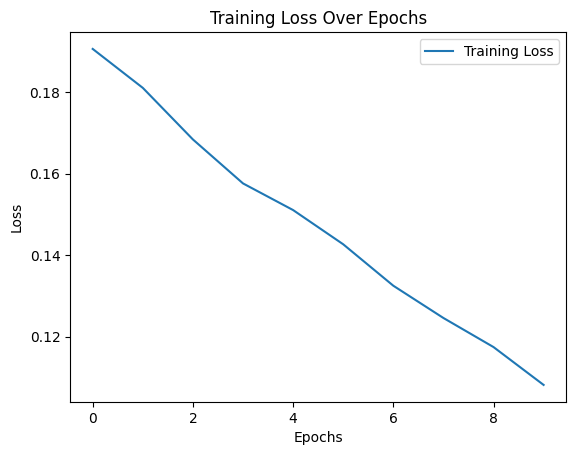

In [ ]:
# Before the training loop, initializing a list to store the average loss per epoch
epoch_losses = []

# Inside training loop the inner loop over mini-batches:
for epoch in range(epochs):
    running_loss = 0.0
    # Indentation starts here for the for loop
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Computing loss
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Updating weights
        optimizer.step()

        running_loss += loss.item()

    # At the end of each epoch, computing the average loss and storing it
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

print('Finished Training')

# Plotting the recorded losses
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

The training loss for the AlexNet model on the Fashion MNIST dataset steadily decreased from around **0.18 to just under 0.10 over 10 epochs, demonstrating successful model learning and convergence.** The visualization succinctly captures this progression, indicating a consistent **improvement in the model's prediction accuracy over time.**

# Part B: Using the ResNet50 (Extra Credit):

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


Epoch 1, Loss: 0.36841582145883456
Epoch 2, Loss: 0.17155358667519174
Epoch 3, Loss: 0.12572586839931257
Epoch 4, Loss: 0.08677504607724515
Epoch 5, Loss: 0.05406149587125333
Epoch 6, Loss: 0.034214321864711274
Epoch 7, Loss: 0.023200724281118447
Epoch 8, Loss: 0.016129210992254065
Epoch 9, Loss: 0.00980119408995185
Epoch 10, Loss: 0.008225191758497796
Finished Training
Accuracy of the network on the test images: 95.09 %


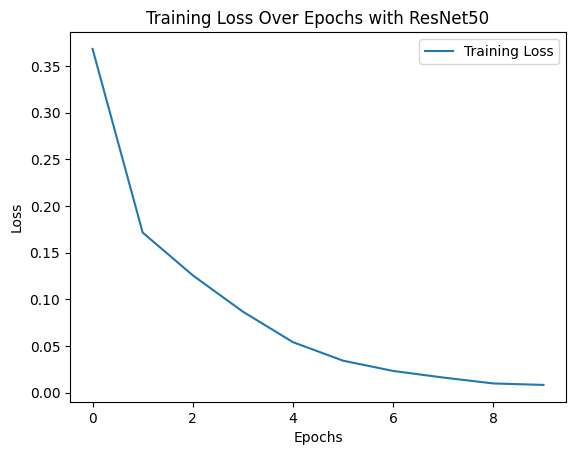

In [ ]:
# Importing the necessary libraries
import torch
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# I already loaded 'train_df' and 'test_df' from Part A

# Defining a custom dataset class for Fashion MNIST
class FashionMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __getitem__(self, index):
        # Getting image data and normalizing to [0, 255]
        image = self.dataframe.iloc[index, 1:].values.astype('uint8').reshape((28, 28))
        # Converting to PIL image
        image = Image.fromarray(image, mode='L').convert('RGB')
        label = int(self.dataframe.iloc[index, 0])

        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataframe)

# Defining transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Creating datasets
train_dataset = FashionMNISTDataset(train_df, transform=transform)
test_dataset = FashionMNISTDataset(test_df, transform=transform)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loading the pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# The final connected layer for 10 classes of Fashion MNIST
model.fc = nn.Linear(model.fc.in_features, 10)

# Transfering to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Defining Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training Loop
epochs = 10  # 10 as per choice in Part A
model.train()  # Setting the model to training mode

# To record epoch losses for visualization
epoch_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

print('Finished Training')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test images: {accuracy} %')

# Visualization of Training Loss
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs with ResNet50')
plt.legend()
plt.show()

The above results indicate that the ResNet50 model, after fine-tuning, performed exceptionally well on the Fashion MNIST dataset. **The training loss decreased significantly from 0.368 in the first epoch to 0.0082 by the tenth epoch, demonstrating strong convergence and effective learning.** Moreover, the model achieved a test accuracy of **95.09%** which is an excellent performance and suggests that the model generalized well from the training data to unseen data. **This successful outcome showcases the capabilities of transfer learning with deep neural networks on image classification tasks.**

# **Comparison of the results from Part A and Part B:**

**Part A (AlexNet):**
- The training loss **decreased** consistently over 10 epochs **starting from around 0.18 and ending just below 0.10.**
- The model achieved an accuracy of **92%** on the test dataset.

**Part B (ResNet50):**
- The training loss showed a more significant **decrease** starting from approximately **0.368 and dropping to 0.0082 by the tenth epoch.**
- The model attained a higher accuracy of **95.09%** on the test dataset.

In comparison, **the ResNet50 model (Part B) outperformed the AlexNet model (Part A) in terms of both the final training loss and the accuracy on the test dataset.** This suggests that **ResNet50 with its deeper architecture and residual connections was more effective for this particular task on the Fashion MNIST dataset.** The more substantial reduction in training loss also **indicates that ResNet50 have a stronger and more efficient learning capability for the features present in the Fashion MNIST dataset.**